**HUMAN ACTIVITY RECOGNITION**






This project is about building a Human Activity recognition  system to be deployed in a web application.                                                For computing resources constraints, we used only 10 classes from [UCF-101](https://www.crcv.ucf.edu/data/UCF101.php).

Import the necessary libraries

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import time
import keras
import tensorflow as tf
import seaborn as sns
import os
import warnings
warnings.filterwarnings(action="ignore")
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from utility import utility
from typing import Optional, Tuple, List
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm


In [45]:
BASE_PATH = 'dataset/' #the folder that already contains the videos of interest
IMG_SIZE = 224 # SIZE of each frame
N_CPU_CORES = os.cpu_count() -1 # the number of cpu to use for paralization 
TEST_SIZE_RATIO = 0.2
IMG_SIZE = 224 #frame size
BATCH_SIZE = 64
EPOCHS = 40
#N_CLASSES = np.unique(dataset_train["Label"])


MAX_SEQ_LENGTH = 20 #max number of frame to collect per videos
NUM_FEATURES = 2048  #size of the feature embedding resulting from convolution




# **1. Overview of the data**

To accomplish this task, we developed a function that go through the folders, extracting various characteristics such as **frame count, frames per second (fps), and duration** for each video and return them as a Dataframe object.

In [97]:
#get an overview of the dataset
dataset = utility.reading_data(base_path)

In [35]:
dataset.head()

,Label,video_path,Frame_count,fps,Duration (s)
0,TrampolineJumping,dataset/TrampolineJumping/v_TrampolineJumping_...,201,29.97003,6.706700
1,TrampolineJumping,dataset/TrampolineJumping/v_TrampolineJumping_...,151,29.97003,5.038367
2,TrampolineJumping,dataset/TrampolineJumping/v_TrampolineJumping_...,151,29.97003,5.038367
3,TrampolineJumping,dataset/TrampolineJumping/v_TrampolineJumping_...,296,29.97003,9.876533
4,TrampolineJumping,dataset/TrampolineJumping/v_TrampolineJumping_...,187,29.97003,6.239567


In [36]:
number_classes = len(dataset["Label"].unique())
number_classes

10

Are we dealing with an imbalanced dataset ?

In [37]:
print("Percentage of video per classes")
dataset.groupby("Label").count()["video_path"] / dataset.shape[0]

Percentage of video per classes


Label
ApplyEyeMakeup       0.112142
BabyCrawling         0.102088
Biking               0.103635
Billiards            0.116009
BrushingTeeth        0.101315
PizzaTossing         0.087394
PushUps              0.078886
Swing                0.101315
TrampolineJumping    0.092034
Typing               0.105182
Name: video_path, dtype: float64

# **2.Preparing the data**

## 2.1 Utility functions

To achieve that, we will define some utility functions that will make our job easier.

## 2.2 Feature extraction using a pre-trained CNN





In [38]:
with ThreadPoolExecutor(max_workers=N_CPU_CORES) as executor:
  #load the videos in parallel on mutiple threads
  frames = tqdm(executor.map(utility.load_video,dataset['video_path']),desc="extracting frames from videos")
  #save the frames as dataframe
  videos_frames = np.array(list(frames))
   


extracting frames from videos: 17it [00:00, 166.49it/s]

extracting frames from videos: 1293it [00:05, 230.17it/s]


In [ ]:
#apply the feature extractor on each frames previously
feature_extractor = utility.build_feature_extractor(IMG_SIZE) #create feature extractor object
with ThreadPoolExecutor(max_workers=N_CPU_CORES) as executor:
  #run the feature extraction in parallel 
  videos_frames_features = tqdm(executor.map(feature_extractor.predict,videos_frames),desc="extracting features from each frames")
  videos_frames_features = np.array(list(videos_frames_features))


In [44]:
print(f"The dataset we have has the following shape: {videos_frames_features.shape}")

The dataset we have has the following shape: (1293, 20, 2048)


## 2.3 Encode labels using labelencoder
Replace activity labels (Pushups, ApplyEyeMakeup,...etc) by integers.

In [48]:
label_processor = tf.keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(dataset["Label"]))
print(label_processor.get_vocabulary())

labels = dataset["Label"].values
labels = label_processor(labels[..., None]).numpy()

['ApplyEyeMakeup', 'BabyCrawling', 'Biking', 'Billiards', 'BrushingTeeth', 'PizzaTossing', 'PushUps', 'Swing', 'TrampolineJumping', 'Typing']


## 2.4 Divide the data into train and test

In [50]:
#define all the variables to be used
N = dataset.shape[0]
N_CLASSES = np.unique(dataset["Label"])
X_train, X_test, y_train, y_test = train_test_split(
    videos_frames_features,labels,
    test_size=TEST_SIZE_RATIO,random_state=N)

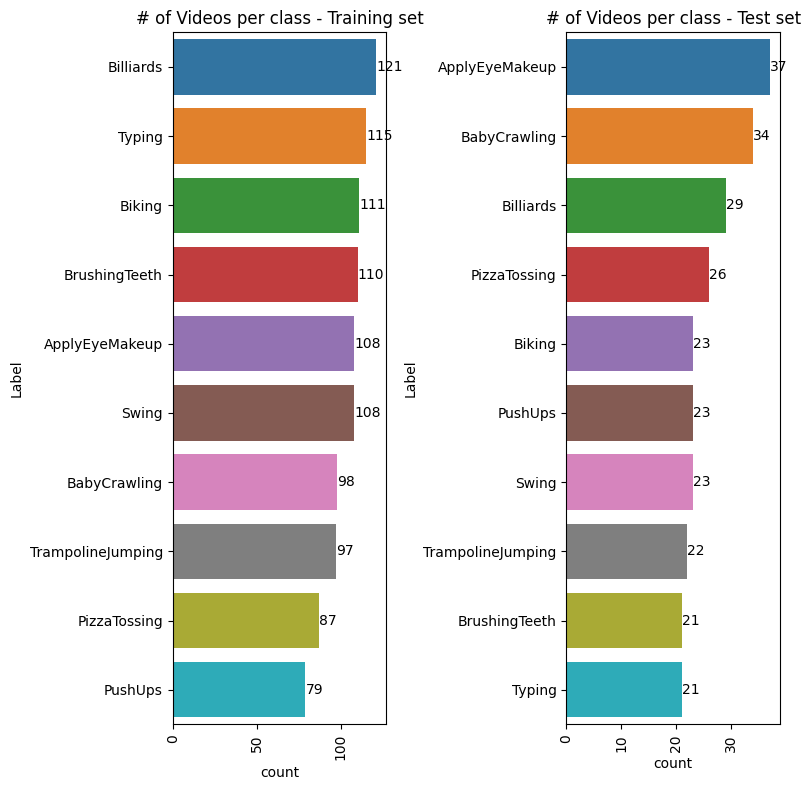

In [69]:
plt.figure(figsize=(8,8))

dataset_train,dataset_test = train_test_split(dataset,test_size=TEST_SIZE_RATIO,random_state=N)
#first subplot
plt.subplot(121)
plt.title("# of Videos per class - Training set")
ax1 = sns.countplot(data=dataset_train,y='Label',palette="tab10",
                    order=dataset_train['Label'].value_counts(ascending=False).index);
plt.xticks(rotation=90)

#second subplot
plt.subplot(122)
plt.title("# of Videos per class - Test set")
ax2 = sns.countplot(data=dataset_test,y='Label',palette="tab10",
                    order=dataset_test['Label'].value_counts(ascending=False).index)
plt.xticks(rotation=90)
plt.tight_layout()
for i,j in zip(ax1.containers,ax2.containers):
    ax1.bar_label(i)
    ax2.bar_label(j)


## 2.5 Apply everything defined so far

In [47]:
# Serialization to avoid preparing the data after each run
#since it's time and resouces consuming
with open("models/video_frames_features.pickle", "wb") as outfile:
    pickle.dump(videos_frames_features, outfile)
print("Written object")


Written object


In [ ]:
# DeSerialization
with open("models/video_frames_features.pickle.pickle", "rb") as infile:
  video_frames_features = pickle.load(infile)
print("Read object")

Read objects


In [106]:
class custGRU(keras.Model):
    def __init__(self,units_1=16,units_2=8,activation="relu",dropout=0.4,max_seq_length=MAX_SEQ_LENGTH,num_features=NUM_FEATURES,n_classes=N_CLASSES):
        super(custGRU,self).__init__()
        self.units_1 = units_1
        self.units_2 = units_2
        self.activation = activation
        self.dropout = dropout
        self.max_seq_length = max_seq_length
        self.num_features = num_features
        self.frame_features_input = keras.Input((self.max_seq_length, self.num_features))
        self.n_classes= n_classes

    def call(self):
        x = keras.layers.GRU(
            self.units_1,return_sequences=True)(self.frame_features_input)
        x = keras.layers.GRU(self.units_2)(x)
        x = keras.layers.dropout(self.dropout)(x)
        x = keras.layers.Dense(self.units_2,activation=self.activation)(x)
        x = keras.layers.Dense(self.n_classes, activation="softmax")(x)
        return x

In [102]:
gru = custGRU()

In [ ]:
gru.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
gru.fit(
        train_data[0],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
)


# **3.Training sequence models**

Create some utility functions to be used later on

In [70]:
MODEL_dict = {"GRU":keras.layers.GRU,"LSTM":keras.layers.LSTM}

In [88]:
def get_sequence_model(model: str, label_processor=label_processor, models_dict=MODEL_dict)->keras.Model:
    """
    Generates a sequence model based on the specified architecture.

    Parameters:
    - model (str): Name of the model architecture t be built.
    - label_processor: Label preprocessor object.
    - models_dict: Dictionary containing available model architectures.

    Returns:
    - Model: Compiled sequence model for training.
    """
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    #mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    #building the Model
    if model == "BILSTM":
          x = keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True))(frame_features_input)
          x = keras.layers.Bidirectional(keras.layers.LSTM(8))(x)
    else:
          x = models_dict[model](16, return_sequences=True)(frame_features_input)
          x = models_dict[model](8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    seq_model = keras.Model(frame_features_input, output)

    seq_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return seq_model


#training function


def run_experiment(model: str, epochs: int = EPOCHS) -> Tuple[keras.callbacks.History, keras.Model]:
    """
    Trains a sequence model based on the specified architecture and runs an experiment.

    parameters:
    - model (str): Name of the model architecture.
    - epochs (int): Number of epochs for training (default: EPOCHS).

    Returns:
    - Tuple[keras.callbacks.History, keras.Model]: Training history and trained model.
    """
    filepath =  "models/"+model + "_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=0
    )

    seq_model = get_sequence_model(model)

    history = seq_model.fit(
        X_train,
        y_train,
        validation_split=0.3,
        epochs=epochs,
        callbacks=[checkpoint],
    )


    seq_model.load_weights(filepath)
    _, acc = seq_model.evaluate(X_test,y_test)
    print(f"Test accuracy: {round(acc * 100, 2)}%")

    return history, seq_model


## 3.1 GRU

In [72]:
gru_model = get_sequence_model("GRU")
print(gru_model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 20, 2048)]        0         
                                                                 
 gru (GRU)                   (None, 20, 16)            99168     
                                                                 
 gru_1 (GRU)                 (None, 8)                 624       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 99954 (390.45 KB)
Trainable params: 99954 (390.

In [75]:
t1 = time.time()
_, gru_model = run_experiment("GRU")
gru_t2 = time.time() - t1
print(f"Training took {gru_t2} s")

Epoch 1/40
23/23 [==============================] - 4s 50ms/step - loss: 2.1322 - accuracy: 0.1853 - val_loss: 1.9276 - val_accuracy: 0.2476
Epoch 2/40
23/23 [==============================] - 1s 23ms/step - loss: 1.9027 - accuracy: 0.2918 - val_loss: 1.7842 - val_accuracy: 0.4405
Epoch 3/40
23/23 [==============================] - 0s 21ms/step - loss: 1.7966 - accuracy: 0.3306 - val_loss: 1.6567 - val_accuracy: 0.4630
Epoch 4/40
23/23 [==============================] - 0s 22ms/step - loss: 1.6869 - accuracy: 0.3970 - val_loss: 1.5210 - val_accuracy: 0.5080
Epoch 5/40
23/23 [==============================] - 1s 22ms/step - loss: 1.5590 - accuracy: 0.4772 - val_loss: 1.4537 - val_accuracy: 0.5338
Epoch 6/40
23/23 [==============================] - 0s 20ms/step - loss: 1.4300 - accuracy: 0.5242 - val_loss: 1.3420 - val_accuracy: 0.6849
Epoch 7/40
23/23 [==============================] - 0s 21ms/step - loss: 1.3801 - accuracy: 0.5297 - val_loss: 1.2656 - val_accuracy: 0.7138
Epoch 8/40
23

**Prediction**

In [76]:
y_pred = gru_model.predict(X_test)
print(classification_report(y_test,np.argmax(y_pred,axis=1)))

9/9 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       0.85      0.65      0.73        34
           2       0.88      1.00      0.94        23
           3       0.97      1.00      0.98        29
           4       0.95      0.90      0.93        21
           5       0.80      0.62      0.70        26
           6       1.00      0.96      0.98        23
           7       0.85      1.00      0.92        23
           8       0.96      1.00      0.98        22
           9       0.70      1.00      0.82        21

    accuracy                           0.90       259
   macro avg       0.90      0.91      0.89       259
weighted avg       0.90      0.90      0.89       259



<Axes: >

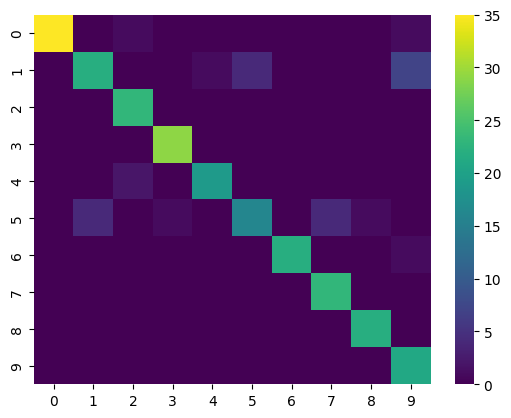

In [77]:
#confusion matrix
sns.heatmap(confusion_matrix(y_test,np.argmax(y_pred,axis=1)),cmap="viridis")

## 3.2 LSTM  

In [78]:
lstm_model = get_sequence_model("LSTM")
print(lstm_model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 20, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 20, 16)            132160    
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 10)                90        
                                                                 
Total params: 133122 (520.01 KB)
Trainable params: 133122 (

In [79]:
t1 = time.time()
_, lstm_model = run_experiment("LSTM")
lstm_t2 = time.time() - t1
print(f"Training of LSTM took {lstm_t2}")

Epoch 1/40
23/23 [==============================] - 4s 54ms/step - loss: 2.2492 - accuracy: 0.1770 - val_loss: 2.1729 - val_accuracy: 0.1608
Epoch 2/40
23/23 [==============================] - 0s 22ms/step - loss: 2.1403 - accuracy: 0.1992 - val_loss: 2.0795 - val_accuracy: 0.2637
Epoch 3/40
23/23 [==============================] - 0s 20ms/step - loss: 2.0611 - accuracy: 0.2503 - val_loss: 1.9861 - val_accuracy: 0.3987
Epoch 4/40
23/23 [==============================] - 1s 24ms/step - loss: 1.9301 - accuracy: 0.3665 - val_loss: 1.8271 - val_accuracy: 0.4791
Epoch 5/40
23/23 [==============================] - 1s 23ms/step - loss: 1.8089 - accuracy: 0.4177 - val_loss: 1.6866 - val_accuracy: 0.5016
Epoch 6/40
23/23 [==============================] - 1s 24ms/step - loss: 1.7139 - accuracy: 0.4509 - val_loss: 1.5424 - val_accuracy: 0.5305
Epoch 7/40
23/23 [==============================] - 1s 28ms/step - loss: 1.5813 - accuracy: 0.5090 - val_loss: 1.4658 - val_accuracy: 0.5338
Epoch 8/40
23

In [81]:
y_pred_lstm = lstm_model.predict(X_test)
print(classification_report(y_test,np.argmax(y_pred_lstm,axis=1)))

9/9 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        37
           1       0.97      0.82      0.89        34
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        29
           4       0.66      0.90      0.76        21
           5       1.00      0.92      0.96        26
           6       0.86      0.83      0.84        23
           7       0.96      1.00      0.98        23
           8       1.00      0.95      0.98        22
           9       1.00      1.00      1.00        21

    accuracy                           0.93       259
   macro avg       0.94      0.94      0.94       259
weighted avg       0.94      0.93      0.94       259



<Axes: >

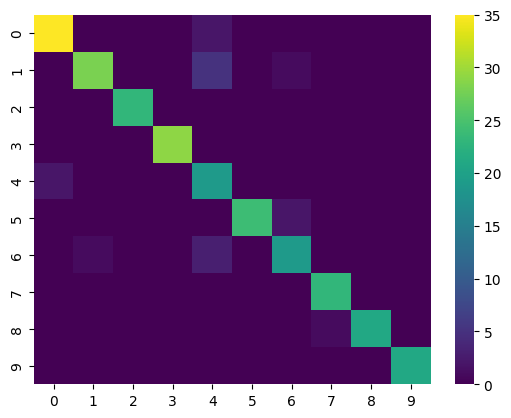

In [82]:
#confusion matrix
sns.heatmap(confusion_matrix(y_test,np.argmax(y_pred_lstm,axis=1)),cmap="viridis")

## 3.3 BI-LSTM

In [83]:
bilstm_model = get_sequence_model("BILSTM")
print(bilstm_model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 20, 2048)]        0         
                                                                 
 bidirectional (Bidirection  (None, 20, 32)            264320    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 16)                2624      
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 10)                90  

In [84]:
t1 = time.time()
_, bilstm_model = run_experiment('BILSTM')
blstm_t2 = time.time() - t1
print(f'Training of BILSTM took : {blstm_t2} s')

Epoch 1/40
23/23 [==============================] - 8s 99ms/step - loss: 2.1480 - accuracy: 0.2144 - val_loss: 1.9671 - val_accuracy: 0.3955
Epoch 2/40
23/23 [==============================] - 1s 36ms/step - loss: 1.9428 - accuracy: 0.3596 - val_loss: 1.8275 - val_accuracy: 0.4695
Epoch 3/40
23/23 [==============================] - 1s 33ms/step - loss: 1.7750 - accuracy: 0.4440 - val_loss: 1.5768 - val_accuracy: 0.4984
Epoch 4/40
23/23 [==============================] - 1s 32ms/step - loss: 1.5513 - accuracy: 0.4938 - val_loss: 1.3679 - val_accuracy: 0.5113
Epoch 5/40
23/23 [==============================] - 1s 31ms/step - loss: 1.3782 - accuracy: 0.5408 - val_loss: 1.2149 - val_accuracy: 0.6431
Epoch 6/40
23/23 [==============================] - 1s 32ms/step - loss: 1.2267 - accuracy: 0.6210 - val_loss: 1.0594 - val_accuracy: 0.7267
Epoch 7/40
23/23 [==============================] - 1s 36ms/step - loss: 1.0840 - accuracy: 0.6653 - val_loss: 0.9575 - val_accuracy: 0.7331
Epoch 8/40
23

In [85]:
y_pred_bilstm = bilstm_model.predict(X_test)
print(classification_report(y_test,np.argmax(y_pred_bilstm,axis=1)))

9/9 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        37
           1       0.97      0.91      0.94        34
           2       0.92      1.00      0.96        23
           3       1.00      1.00      1.00        29
           4       0.87      0.95      0.91        21
           5       0.56      0.96      0.70        26
           6       0.33      0.04      0.08        23
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        22
           9       1.00      1.00      1.00        21

    accuracy                           0.89       259
   macro avg       0.86      0.88      0.85       259
weighted avg       0.87      0.89      0.86       259



<Axes: >

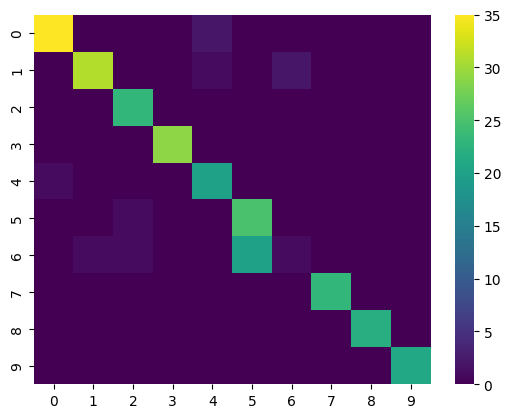

In [86]:
sns.heatmap(confusion_matrix(y_test,np.argmax(y_pred_bilstm,axis=1)),cmap="viridis")

# **4.Results**


**Testing the model using a random video downloaded from internet**

The test video from the internet shows a man doing pushups


In [120]:
test_online_video_path = "test/PushUp.mp4"

In [123]:
frames = utility.load_video(test_online_video_path)
class_vocab = label_processor.get_vocabulary()
frame_features = feature_extractor.predict(frames).reshape(1,20,2048)
probabilities = gru_model.predict(frame_features)[0]
max_label = class_vocab[np.argsort(probabilities)[-1]]
for i in np.argsort(probabilities)[::-1]:
    print(f"{class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

1/1 [==============================] - 0s 18ms/step
PushUps: 84.77%
TrampolineJumping:  5.38%
ApplyEyeMakeup:  4.34%
Biking:  3.93%
Typing:  1.29%
Swing:  0.15%
BabyCrawling:  0.06%
PizzaTossing:  0.05%
Billiards:  0.03%
BrushingTeeth:  0.01%


**Comment:**

From the training and testing accuracy results of our trained models (LSTM, GRU, and BILSTM), it's clear they excel in classifying human activities. Assessing the confusion matrices for each model, we notice values being 0 almost everywhere around the diagonal, showcasing remarkable performance. Yet, considering the training duration, BILSTM takes nearly double the time of LSTM and GRU models. Consequently, we'll opt for **LSTM** as our deployment model for production.

In [ ]:
#save the model to be deployed in production

In [ ]:
lstm_model.save("models/final_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
